# [RTS-GMLC](https://github.com/gridmod/rts-gmlc) & [PowerSimulations.jl](https://github.com/NREL/PowerSimulations.jl)

This notebook demonstrates how to run production cost modeling and other simulations on the RTS-GMLC data using PowerSimulations.jl

*This notebook was developed on 9/12/2019 using [a development branch of PowerSimulations.jl](https://github.com/NREL/PowerSimulations.jl/commit/c8e8bb5b02b149351c4b5036e8349b971aa2e3c0) - stability is unlikely*


In [1]:
] activate env

Activating environment at `~/Documents/repos/Examples/env/Project.toml`


In [2]:
] st

    Status `~/Documents/repos/Examples/env/Project.toml`
  [5ae59095] Colors v0.9.6
  [41994980] D3TypeTrees v0.1.1
  [a93c6f00] DataFrames v0.19.4
  [e2685f51] ECOS v0.10.0
  [60bf3e95] GLPK v0.11.4
  [b6b21f68] Ipopt v0.6.0
  [4076af6c] JuMP v0.20.0
  [51fcb6bd] NamedColors v0.2.0
  [f0f68f2c] PlotlyJS v0.12.5
  [91a5bcdd] Plots v0.26.3
  [e690365d] PowerSimulations v0.2.0 #jd/sim_update (https://github.com/NREL/PowerSimulations.jl.git)
  [bcd98974] PowerSystems v0.4.0 #master (https://github.com/NREL/PowerSystems.jl.git)
  [9e3dc215] TimeSeries v0.16.0
  [0f1e0344] WebIO v0.8.11


In [3]:
using Revise
using PowerSystems
using PowerSimulations
const PSY = PowerSystems
const PSI = PowerSimulations
const IS = PSY.InfrastructureSystems

InfrastructureSystems

In [4]:
using JuMP
using Dates

In [5]:
# not working
using Xpress
Xpress_optimizer = JuMP.with_optimizer(Xpress.Optimizer,OUTPUTLOG = 1,MIPTOL=1e-6,FEASTOL=1e-6)


ArgumentError: ArgumentError: Package Xpress not found in current path:
- Run `import Pkg; Pkg.add("Xpress")` to install the Xpress package.


In [9]:
using GLPK
GLPK_optimizer = JuMP.with_optimizer(GLPK.Optimizer)

┌ Info: Recompiling stale cache file /Users/cbarrows/.julia/compiled/v1.2/GLPK/r6CoY.ji for GLPK [60bf3e95-4087-53dc-ae20-288a0d20c6a6]
└ @ Base loading.jl:1240


OptimizerFactory(GLPK.Optimizer, (), Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}())

In [10]:
using Cbc
Cbc_optimizer = JuMP.with_optimizer(Cbc.Optimizer, logLevel=1, ratioGap=0.1)

OptimizerFactory(Cbc.Optimizer, (), Base.Iterators.Pairs{Symbol,Real,Tuple{Symbol,Symbol},NamedTuple{(:logLevel, :ratioGap),Tuple{Int64,Float64}}}(:logLevel => 1,:ratioGap => 0.1))

## Get the RTS data

In [13]:
# path to "reformat-DC" branch of RTS-GMLC repo: https://github.com/GridMod/RTS-GMLC/tree/reformat-DC
RTSDIR = "../RTS-GMLC/RTS_Data/SourceData/."

"../RTS-GMLC/RTS_Data/SourceData/."

In [14]:
rts_data = PSY.PowerSystemTableData(RTSDIR, 
    100.0,joinpath(RTSDIR,"../FormattedData/SIIP/user_descriptors.yaml"))

┌ Info: Parsing csv data in branch.csv ...
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:151
┌ Info: Successfully parsed branch.csv
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:156
┌ Info: Parsing csv data in bus.csv ...
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:151
┌ Info: Successfully parsed bus.csv
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:156
┌ Info: Parsing csv data in dc_branch.csv ...
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:151
┌ Info: Successfully parsed dc_branch.csv
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:156
┌ Info: Parsing csv data in gen.csv ...
└ @ PowerSystems /Users/cbarrows/.julia/packages

PowerSystems.PowerSystemTableData:
  directory:  ../RTS-GMLC/RTS_Data/SourceData/.
  timeseries_metadata_file:  ../RTS-GMLC/RTS_Data/SourceData/./timeseries_pointers.csv
  basepower:  100.0
  branch:  120×14 DataFrames.DataFrame
  bus:  73×15 DataFrames.DataFrame
  dcline:  1×60 DataFrames.DataFrame
  gen:  158×57 DataFrames.DataFrame
  load:  no data
  services:  7×5 DataFrames.DataFrame


In [15]:
sys_DA = System(rts_data; forecast_resolution = Dates.Hour(1))

┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in datafr

┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in datafr

┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in datafr

┌ Warning: User-defined column name Devices is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Requirement is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Eligible Generator Categories is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Reserve Category is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Variable Cost is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Fixed Cost is not in dataframe.
└ @ PowerSy

┌ Warning: Did not find component for forecast category=Generator name=212_CSP_HEAD_STORAGE
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/system_data.jl:275
┌ Warning: Did not find component for forecast category=Generator name=212_CSP_HEAD_STORAGE
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/system_data.jl:275


,ConcreteType,SuperTypes,Count
,String,String,Int64
1,Bus,Topology <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,73
2,GenericBattery,Storage <: Injection <: Device <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,1
3,HVDCLine,DCBranch <: Branch <: Device <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,1
4,HydroDispatch,HydroGen <: Generator <: Injection <: Device <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,20
5,Line,ACBranch <: Branch <: Device <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,104
6,LoadZones,Topology <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,3
7,PowerLoad,StaticLoad <: ElectricLoad <: Injection <: Device <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,73
8,ProportionalReserve,Reserve <: Service <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,7
9,RenewableDispatch,RenewableGen <: Generator <: Injection <: Device <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,30


In [16]:
sys_RT = System(rts_data; forecast_resolution = Dates.Minute(5))

┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in datafr

┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in datafr

┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in datafr

┌ Warning: User-defined column name Variable Cost is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Fixed Cost is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Start-up Cost is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Shutdown Cost is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Capacity Factor is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Curtailment Cost is not in dataframe.
└ @ PowerSystems 

┌ Warning: User-defined column name Interruption Cost is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Power Factor is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Generator Category is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Variable Cost is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Fixed Cost is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/RItCb/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Start-up Cost is not in dataframe.
└ @ PowerSyste

,ConcreteType,SuperTypes,Count
,String,String,Int64
1,Bus,Topology <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,73
2,GenericBattery,Storage <: Injection <: Device <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,1
3,HVDCLine,DCBranch <: Branch <: Device <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,1
4,HydroDispatch,HydroGen <: Generator <: Injection <: Device <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,20
5,Line,ACBranch <: Branch <: Device <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,104
6,LoadZones,Topology <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,3
7,PowerLoad,StaticLoad <: ElectricLoad <: Injection <: Device <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,73
8,ProportionalReserve,Reserve <: Service <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,7
9,RenewableDispatch,RenewableGen <: Generator <: Injection <: Device <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,30


In [17]:
 get_forecast_initial_times(sys_DA)

1-element Array{DateTime,1}:
 2020-01-01T00:00:00

In [18]:
function subset_forecasts!(sys, forecast_type, initial_time, from_time, to_time)
    fcs = get_forecasts(forecast_type, sys, initial_time)
    new_fcs = []
    for fc in fcs
        res = IS.get_resolution(fc)
        new_fc = Deterministic(get_component(fc),
            IS.get_label(fc), 
            res, 
            from_time,
            PSY.get_data(fc)[from_time:res:to_time])
        push!(new_fcs, new_fc)
    end
    [remove_forecast!(sys, fc) for fc in fcs]
    [PSY.add_forecast!(sys, new_fc) for new_fc in new_fcs]

end

subset_forecasts! (generic function with 1 method)

In [19]:
subset_forecasts!(sys_DA, Deterministic, 
    get_forecast_initial_times(sys_DA)[1], 
    DateTime("2020-04-04T00:00:00"), 
    DateTime("2020-04-12T23:00:00"));

┌ Info: Deleted forecast 192e5c35-ed9e-42ab-bb01-2d4102e89839
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast cecc5750-38ba-4f30-a9a1-1ae96be866c0
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast f96a3c05-98b7-4fbe-8254-a833a4ed6eed
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast 438ab5c3-b5fb-471e-84ea-077738ddbf2c
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast d8900f95-94f6-49d3-9af3-52b4e31b7573
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast 1fc8c25e-bbdb-4444-9931-9eab4d929d76
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/for

┌ Info: Deleted forecast 4acf45e1-ea07-4829-a164-2c74e40fa80e
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast 950a8ffb-5b22-4ffb-8f36-6f338a74de14
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast b44038bb-a795-42b2-aa9d-bd43242c2ac1
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast a3c3b4a3-f49b-4630-8a68-a66cd01dbd6c
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast 0d311dca-089d-402e-8834-f821d279e7de
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast a23465ea-abbd-4c93-95dd-b1e66a6e88f9
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/for

┌ Info: Deleted forecast 36151819-6400-4522-9d9f-697d8e20a2e5
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast 6922a88d-f8d7-4feb-9caa-8b8131a15306
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast 5fa1e80d-a61b-48e4-b6c1-2d4a070580c8
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast 429ef331-324a-4344-9541-5806e6186f88
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast e2adf337-7019-4eb2-ad76-f1412eb67223
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast 9f5be025-e2f7-4d25-9822-152a01ded360
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/for

┌ Info: Deleted forecast a0c190ed-e7a7-4e2c-9e86-5da06ef09aa7
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast d500aabb-4c2b-455a-94a9-bf5a4472cc82
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast 120ce58d-602f-4b16-a575-6a6cf5cda6d2
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast 8f1a3873-ae6e-4b53-aded-8802971da60a
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast def16344-2a2a-4cd9-9b49-37a899e92652
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast f29b8971-d2c5-40c9-a762-6f707a2a1945
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/for

In [20]:
PSY.get_forecast_initial_times(sys_DA)

1-element Array{DateTime,1}:
 2020-04-04T00:00:00

In [21]:
split_forecasts!(sys_DA, 
    get_forecasts(Deterministic, sys_DA, PSY.get_forecast_initial_times(sys_DA)[1]),
    Dates.Hour(24),
    48)

┌ Info: Created forecast with
│   initial_time = 2020-04-04T00:00:00
│   horizon = 48
│   component = ProportionalReserve("Flex_Down", Device[ThermalStandard("101_CT_1", true, Bus(101, "Abel", PowerSystems.PV, -0.13511501310899143, 1.04777, (min = 0.95, max = 1.05), 138.0, InfrastructureSystems.InfrastructureSystemsInternal(UUID("399f05c0-891d-4518-8cde-7f33e440748f"))), 0.08, 0.0496, TechThermal(0.223606797749979, PowerSystems.CT, PowerSystems.DISTILLATE_FUEL_OIL, (min = 0.08, max = 0.2), (min = 0.0, max = 0.1), (up = 0.03, down = 0.03), (up = 1.0, down = 1.0), InfrastructureSystems.InfrastructureSystemsInternal(UUID("03f56c91-eac0-4870-9282-c6950ae3a6d4"))), ThreePartCost(PowerSystems.VariableCost{Array{Tuple{Float64,Float64},1}}(Tuple{Float64,Float64}[(1085.7762528, 0.08000000000000002), (1477.2319584, 0.12), (1869.5156160000001, 0.16000000000000003), (2298.0635712000003, 0.2)]), 0.0, 51.747, 0.0, InfrastructureSystems.InfrastructureSystemsInternal(UUID("975af4bc-892d-49a5-84c4-7551

┌ Info: Created forecast with
│   initial_time = 2020-04-05T00:00:00
│   horizon = 48


│   component = ProportionalReserve("Flex_Down", Device[ThermalStandard("101_CT_1", true, Bus(101, "Abel", PowerSystems.PV, -0.13511501310899143, 1.04777, (min = 0.95, max = 1.05), 138.0, InfrastructureSystems.InfrastructureSystemsInternal(UUID("399f05c0-891d-4518-8cde-7f33e440748f"))), 0.08, 0.0496, TechThermal(0.223606797749979, PowerSystems.CT, PowerSystems.DISTILLATE_FUEL_OIL, (min = 0.08, max = 0.2), (min = 0.0, max = 0.1), (up = 0.03, down = 0.03), (up = 1.0, down = 1.0), InfrastructureSystems.InfrastructureSystemsInternal(UUID("03f56c91-eac0-4870-9282-c6950ae3a6d4"))), ThreePartCost(PowerSystems.VariableCost{Array{Tuple{Float64,Float64},1}}(Tuple{Float64,Float64}[(1085.7762528, 0.08000000000000002), (1477.2319584, 0.12), (1869.5156160000001, 0.16000000000000003), (2298.0635712000003, 0.2)]), 0.0, 51.747, 0.0, InfrastructureSystems.InfrastructureSystemsInternal(UUID("975af4bc-892d-49a5-84c4-7551a5e11c0c"))), InfrastructureSystems.InfrastructureSystemsInternal(UUID("536ed96a-a63a-

│   component = ProportionalReserve("Flex_Down", Device[ThermalStandard("101_CT_1", true, Bus(101, "Abel", PowerSystems.PV, -0.13511501310899143, 1.04777, (min = 0.95, max = 1.05), 138.0, InfrastructureSystems.InfrastructureSystemsInternal(UUID("399f05c0-891d-4518-8cde-7f33e440748f"))), 0.08, 0.0496, TechThermal(0.223606797749979, PowerSystems.CT, PowerSystems.DISTILLATE_FUEL_OIL, (min = 0.08, max = 0.2), (min = 0.0, max = 0.1), (up = 0.03, down = 0.03), (up = 1.0, down = 1.0), InfrastructureSystems.InfrastructureSystemsInternal(UUID("03f56c91-eac0-4870-9282-c6950ae3a6d4"))), ThreePartCost(PowerSystems.VariableCost{Array{Tuple{Float64,Float64},1}}(Tuple{Float64,Float64}[(1085.7762528, 0.08000000000000002), (1477.2319584, 0.12), (1869.5156160000001, 0.16000000000000003), (2298.0635712000003, 0.2)]), 0.0, 51.747, 0.0, InfrastructureSystems.InfrastructureSystemsInternal(UUID("975af4bc-892d-49a5-84c4-7551a5e11c0c"))), InfrastructureSystems.InfrastructureSystemsInternal(UUID("536ed96a-a63a-

│   component = ProportionalReserve("Flex_Down", Device[ThermalStandard("101_CT_1", true, Bus(101, "Abel", PowerSystems.PV, -0.13511501310899143, 1.04777, (min = 0.95, max = 1.05), 138.0, InfrastructureSystems.InfrastructureSystemsInternal(UUID("399f05c0-891d-4518-8cde-7f33e440748f"))), 0.08, 0.0496, TechThermal(0.223606797749979, PowerSystems.CT, PowerSystems.DISTILLATE_FUEL_OIL, (min = 0.08, max = 0.2), (min = 0.0, max = 0.1), (up = 0.03, down = 0.03), (up = 1.0, down = 1.0), InfrastructureSystems.InfrastructureSystemsInternal(UUID("03f56c91-eac0-4870-9282-c6950ae3a6d4"))), ThreePartCost(PowerSystems.VariableCost{Array{Tuple{Float64,Float64},1}}(Tuple{Float64,Float64}[(1085.7762528, 0.08000000000000002), (1477.2319584, 0.12), (1869.5156160000001, 0.16000000000000003), (2298.0635712000003, 0.2)]), 0.0, 51.747, 0.0, InfrastructureSystems.InfrastructureSystemsInternal(UUID("975af4bc-892d-49a5-84c4-7551a5e11c0c"))), InfrastructureSystems.InfrastructureSystemsInternal(UUID("536ed96a-a63a-

│   component = ProportionalReserve("Flex_Down", Device[ThermalStandard("101_CT_1", true, Bus(101, "Abel", PowerSystems.PV, -0.13511501310899143, 1.04777, (min = 0.95, max = 1.05), 138.0, InfrastructureSystems.InfrastructureSystemsInternal(UUID("399f05c0-891d-4518-8cde-7f33e440748f"))), 0.08, 0.0496, TechThermal(0.223606797749979, PowerSystems.CT, PowerSystems.DISTILLATE_FUEL_OIL, (min = 0.08, max = 0.2), (min = 0.0, max = 0.1), (up = 0.03, down = 0.03), (up = 1.0, down = 1.0), InfrastructureSystems.InfrastructureSystemsInternal(UUID("03f56c91-eac0-4870-9282-c6950ae3a6d4"))), ThreePartCost(PowerSystems.VariableCost{Array{Tuple{Float64,Float64},1}}(Tuple{Float64,Float64}[(1085.7762528, 0.08000000000000002), (1477.2319584, 0.12), (1869.5156160000001, 0.16000000000000003), (2298.0635712000003, 0.2)]), 0.0, 51.747, 0.0, InfrastructureSystems.InfrastructureSystemsInternal(UUID("975af4bc-892d-49a5-84c4-7551a5e11c0c"))), InfrastructureSystems.InfrastructureSystemsInternal(UUID("536ed96a-a63a-

In [22]:
subset_forecasts!(sys_RT, Deterministic, 
    get_forecast_initial_times(sys_RT)[1], 
    DateTime("2020-04-04T00:00:00"), 
    DateTime("2020-04-12T23:00:00"));

┌ Info: Deleted forecast 8281a6eb-c9b8-41b8-97f8-b2a6d0722781
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast 485350bf-3b8a-421c-b88c-8832fb2a10e7
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast 0bb4f7fd-2a3b-4e42-8a39-e7c98403051b
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast 9f1212ba-27b9-4aa4-9b8c-2505f496f2de
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast 899529eb-f1a6-41bb-bef5-676e56c905ff
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast 250cbe5c-c0db-4271-beb3-7151b2824949
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/for

┌ Info: Deleted forecast 829e8b2b-56f1-4fee-998d-d806cc5c1979
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast 7c2c5ecb-07e3-4faf-a4cc-f732c5826efe
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast 26097efa-c884-4f47-8ef7-d68d7d7b77a7
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast 2d5ca43e-572c-4f5a-b411-e4e40c7a4cb9
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast 1d5bbda9-d29d-4fd9-813b-1f39c4c981f4
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast 0a3a806d-459d-48e1-87e9-faa6e321d49f
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/for

┌ Info: Deleted forecast 15ea29e1-93f5-4669-97ac-feafd34aa41a
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast 185abc90-1902-4391-ba5c-a866cc49484a
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast c1d33aca-04da-4425-8088-2ed5ea8a51db
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast 24779d45-3751-433a-bf59-61416a2f0e80
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast 24b91efb-5e70-4899-a449-0da2e982f946
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast 78d8fbdf-42ea-4623-b3b3-7b2d15a6fa2f
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/for

┌ Info: Deleted forecast 7aea1785-19e6-4c0b-bf25-e90f6c3343ee
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast c5f51604-f79e-4ab4-9f9a-5be1328d170d
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast 20a01b68-7d14-4dd4-8f7e-8567581610f3
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast 32ccde72-03ed-44a4-b367-01f44944dbe2
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast d54ae448-6f6a-4b74-b5e4-a66856995e26
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:407
┌ Info: Deleted forecast cc89560b-9b13-4f59-a7ef-beacabb383f5
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/for

In [23]:
split_forecasts!(sys_RT, 
    get_forecasts(Deterministic, sys_RT, get_forecast_initial_times(sys_RT)[1]),
    Dates.Minute(5),
    12)

┌ Info: Reset system forecast information.
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/8cF6H/src/forecasts.jl:107


In [25]:
# TODO: load from here.
to_json(sys_DA,"sys_DA_44_412.json")
to_json(sys_RT,"sys_RT_44_412.json")

## Setup Single-Step Problem

In [28]:
## UC Model Ref
branches = Dict{Symbol, DeviceModel}(#:L => DeviceModel(PSY.Line, PSI.StaticLine),
                                     #:T => DeviceModel(PSY.Transformer2W, PSI.StaticTransformer),
                                     #:TT => DeviceModel(PSY.TapTransformer, PSI.StaticTransformer),
                                     #:dc_line => DeviceModel(PSY.HVDCLine, PSI.HVDCDispatch)
                                    )

services = Dict{Symbol, PSI.ServiceModel}()

devices = Dict{Symbol, DeviceModel}(:Generators => DeviceModel(PSY.ThermalStandard, PSI.ThermalBasicUnitCommitment),
                                    :Ren => DeviceModel(PSY.RenewableDispatch, PSI.RenewableFullDispatch),
                                    :Loads =>  DeviceModel(PSY.PowerLoad, PSI.StaticPowerLoad),
                                    #:ILoads =>  DeviceModel(PSY.InterruptibleLoad, PSI.StaticPowerLoad),
                                    )       


model_ref_uc= ModelReference(CopperPlatePowerModel, devices, branches, services);

In [29]:
struct foo <: PSI.AbstractOperationModel end


In [30]:
op_model = OperationModel(foo, model_ref_uc, sys_DA, optimizer = Cbc_optimizer)

┌ Info: Building ThermalStandard with ThermalBasicUnitCommitment formulation
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/PVajx/src/core/build_operations.jl:14
┌ Info: Setting DeviceStatus initial conditions for the status of all devices ThermalStandard based on system data
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/PVajx/src/routines/make_initial_conditions.jl:19
┌ Info: Setting DevicePower initial_condition of all devices ThermalStandard based on system data
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/PVajx/src/routines/make_initial_conditions.jl:57
┌ Info: Setting TimeDurationON initial_condition of all devices ThermalStandard based on system data
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/PVajx/src/routines/make_initial_conditions.jl:97
┌ Info: Setting TimeDurationOFF initial_condition of all devices ThermalStandard based on system data
└ @ PowerSimulations /Users/cbarrows/.juli


Operation Model

  transmission:  CopperPlatePowerModel

  devices: 
      Generators:
        device = ThermalStandard
        formulation = ThermalBasicUnitCommitment
      Ren:
        device = RenewableDispatch
        formulation = RenewableFullDispatch
      Loads:
        device = PowerLoad
        formulation = StaticPowerLoad


  branches: 


  services:  Dict{Symbol,PowerSimulations.ServiceModel}()



In [31]:
res = solve_op_model!(op_model)

┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{Cbc.Optimizer,MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.Model{Float64}}}}. This 
│   information will be discarded. = information will be discarded.
└ @ MathOptInterface.Utilities /Users/cbarrows/.julia/packages/MathOptInterface/WXD0G/src/Utilities/copy.jl:140
┌ Warning: SolveTime() property not supported by COIN Branch-and-Cut (Cbc)
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/PVajx/src/routines/get_results.jl:76


Welcome to the CBC MILP Solver 
Version: 2.9.9 
Build Date: Dec 31 2018 

command line - Cbc_C_Interface -ratioGap 0.1 -logLevel 1 -solve -quit (default strategy 1)
ratioGap was changed from 0 to 0.1
Continuous objective value is 1.9061e+06 - 0.38 seconds
Cgl0004I processed model has 17671 rows, 28162 columns (10786 integer (10786 of which binary)) and 56355 elements
Cbc0038I Initial state - 567 integers unsatisfied sum - 147.794
Cbc0038I Pass   1: (0.75 seconds) suminf.    4.46719 (31) obj. 2.02434e+06 iterations 3363
Cbc0038I Pass   2: (0.77 seconds) suminf.    0.57622 (16) obj. 2.02785e+06 iterations 85
Cbc0038I Pass   3: (0.79 seconds) suminf.    0.00000 (0) obj. 2.16348e+06 iterations 114
Cbc0038I Solution found of 2.16348e+06
Cbc0038I Relaxing continuous gives 2.13854e+06
Cbc0038I Before mini branch and bound, 10188 integers at bound fixed and 15480 continuous
Cbc0038I Full problem 17671 rows 28162 columns, reduced to 132 rows 435 columns
Cbc0038I Mini branch and bound improved s

Results Model


In [32]:
res.variables[:ON_ThermalStandard]

,322_CT_6,321_CC_1,202_STEAM_3,315_STEAM_1,223_CT_4,123_STEAM_2,213_CT_1,223_CT_6
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
9,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### Plotting results is a work in progress

In [33]:
using Plots
gr()

Plots.GRBackend()

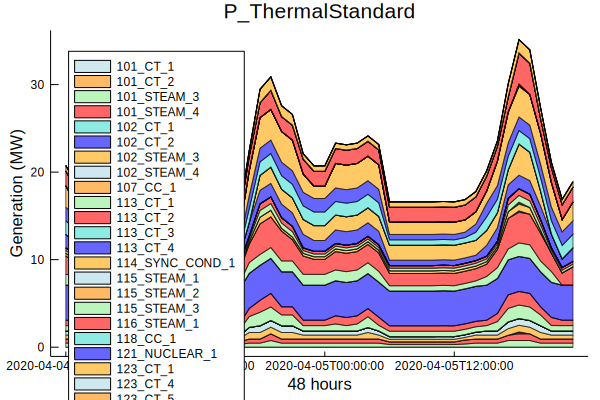

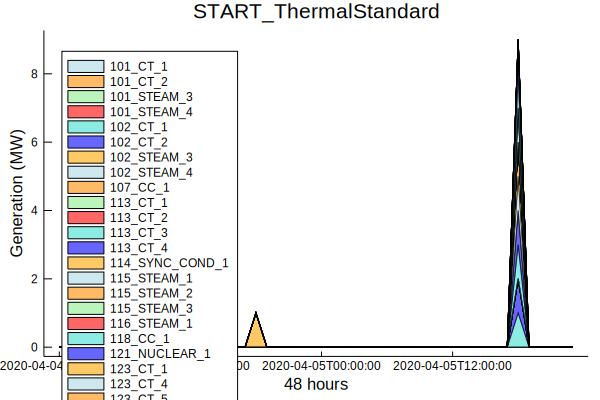

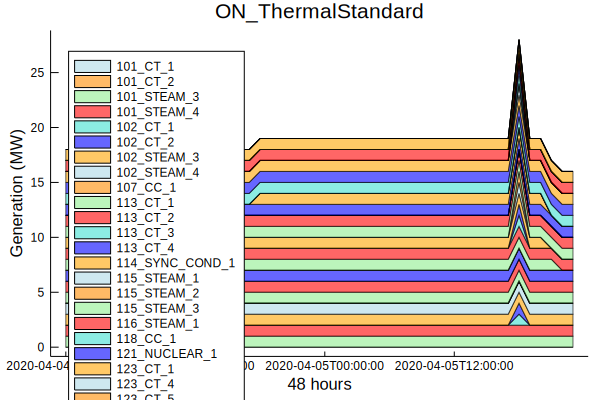

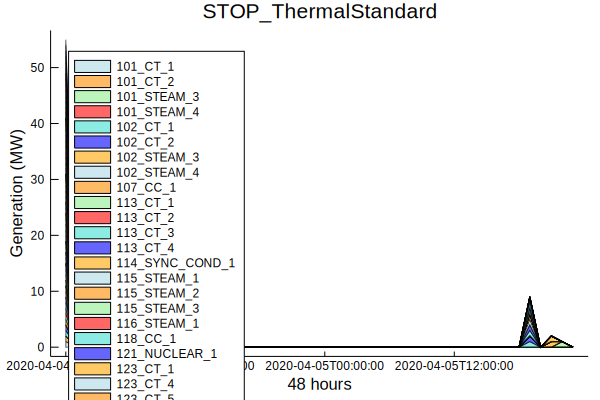

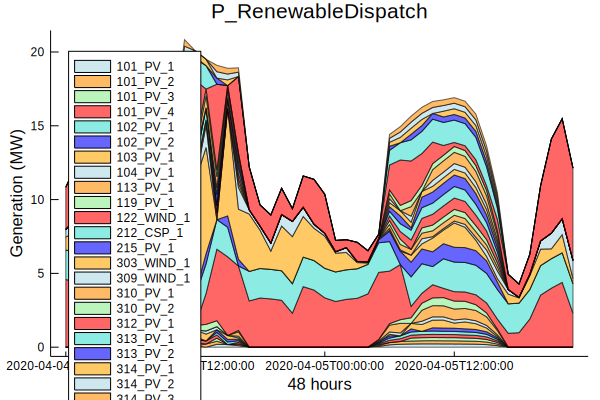

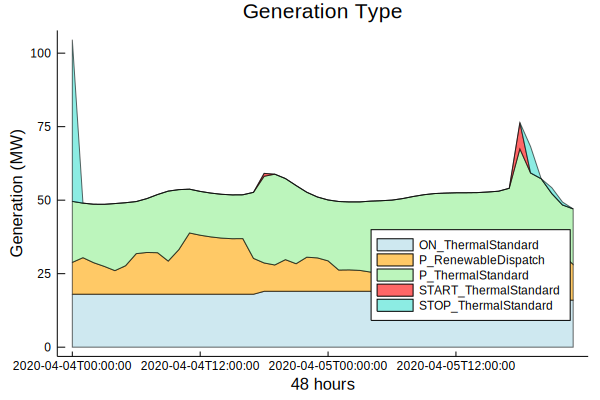

In [34]:
PSI.stack_plot(res)

## Setup sequential simulations

In [35]:
## UC Model Ref
branches = Dict{Symbol, DeviceModel}(#:L => DeviceModel(PSY.Line, PSI.StaticLine),
                                     #:T => DeviceModel(PSY.Transformer2W, PSI.StaticTransformer),
                                     #:TT => DeviceModel(PSY.TapTransformer, PSI.StaticTransformer),
                                     #:dc_line => DeviceModel(PSY.HVDCLine, PSI.HVDCDispatch)
                                    )

services = Dict{Symbol, PSI.ServiceModel}()

devices = Dict{Symbol, DeviceModel}(:Generators => DeviceModel(PSY.ThermalStandard, PSI.ThermalBasicUnitCommitment),
                                    :Ren => DeviceModel(PSY.RenewableDispatch, PSI.RenewableFullDispatch),
                                    :Loads =>  DeviceModel(PSY.PowerLoad, PSI.StaticPowerLoad),
                                    #:ILoads =>  DeviceModel(PSY.InterruptibleLoad, PSI.StaticPowerLoad),
                                    )       


model_ref_uc= ModelReference(CopperPlatePowerModel, devices, branches, services);

In [36]:
## ED Model Ref
branches = Dict{Symbol, DeviceModel}(#:L => DeviceModel(PSY.Line, PSI.StaticLine),
                                     #:T => DeviceModel(PSY.Transformer2W, PSI.StaticTransformer),
                                     #:TT => DeviceModel(PSY.TapTransformer, PSI.StaticTransformer),
                                     #:dc_line => DeviceModel(PSY.HVDCLine, PSI.HVDCDispatch)
                                        )

services = Dict{Symbol, PSI.ServiceModel}()

devices = Dict{Symbol, DeviceModel}(:Generators => DeviceModel(PSY.ThermalStandard, PSI.ThermalDispatch, SemiContinuousFF(:P, :ON)),
                                    :Ren => DeviceModel(PSY.RenewableDispatch, PSI.RenewableFullDispatch),
                                    :Loads =>  DeviceModel(PSY.PowerLoad, PSI.StaticPowerLoad),
                                    #:ILoads =>  DeviceModel(PSY.InterruptibleLoad, PSI.DispatchablePowerLoad),
                                    )       

model_ref_ed= ModelReference(CopperPlatePowerModel, devices, branches, services);

In [37]:
stages = Dict(1 => Stage(model_ref_uc, 1, sys_DA, GLPK_optimizer),
              2 => Stage(model_ref_ed, 24, sys_RT, GLPK_optimizer,  Dict(1 => Synchronize)))

Dict{Int64,Stage} with 2 entries:
  2 => Simulation Stage…
  1 => Simulation Stage…

In [38]:
sim = Simulation("test", 1, stages, "/Users/cbarrows/Downloads/"; verbose = true, system_to_file = false)

┌ Info: Building Stage 2
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/PVajx/src/core/build_simulations.jl:81
┌ Info: Building ThermalStandard with ThermalDispatch formulation
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/PVajx/src/core/build_operations.jl:14
┌ Info: Building RenewableDispatch with RenewableFullDispatch formulation
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/PVajx/src/core/build_operations.jl:14
┌ Info: Building PowerLoad with StaticPowerLoad formulation
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/PVajx/src/core/build_operations.jl:14
┌ Info: Building CopperPlatePowerModel network formulation
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/PVajx/src/core/build_operations.jl:19
┌ Info: Building Objective
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/PVajx/src/core/build_operations.jl:34
┌ Info: Building Stage 1
└ @ PowerSimula

Simulation Model


In [ ]:
res = run_sim_model!(sim)